# Introduction to Deep Learning 
## Professor Vahid Tarokh
### Student: Ashley, John, Ryan, Julian
#### Team Project
#### C-VAE on Fashion MNIST




##### Disclaimer: ChatGPT was used for creating the solution to the project assignment.
##### Disclaimer: Solution partly based on HW5.

In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.optim import Adam
from torch.optim import RAdam

import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from torchmetrics.image import StructuralSimilarityIndexMeasure
from torchmetrics.image.fid import FrechetInceptionDistance

In [2]:
# setting seed for replicability
SEED = 12062024
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# device & tensor configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

#### Load Fashion MNIST dataset and pass to data loader

In [3]:
# batch size
batch_size = 128

# define transformations
transform = transforms.Compose(
    [transforms.ToTensor()]) # scales pixel values to [0, 1]

# load Fashion-MNIST dataset
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

### C-VAE

Solution based on lecture slides and *Part_10a_VAE.ipynb* from the discussion section.

In [4]:
class ConditionalVAE(nn.Module):
    def __init__(self, n_in, n_hid, z_dim, n_classes):
        """
        Args:
            n_in: Dimensionality of the input.
            n_hid: Number of hidden units.
            z_dim: Dimensionality of the latent space.
            n_classes: Number of classes for conditioning.
        """
        super().__init__()

        # Embedding layer for class labels
        self.n_classes = n_classes
        self.class_embedding = nn.Embedding(n_classes, embed_dim)

        # Encoder layers
        self.fc1 = nn.Linear(n_in + embed_dim, n_hid) # change to n_in + n_classes for one-hot encoding
        self.fc2 = nn.Linear(n_hid, n_hid)
        self.fc31 = nn.Linear(n_hid, z_dim)
        self.fc32 = nn.Linear(n_hid, z_dim)

        # Decoder layers
        self.fc4 = nn.Linear(z_dim + embed_dim, n_hid)
        self.fc5 = nn.Linear(n_hid, n_hid)
        self.fc6 = nn.Linear(n_hid, n_in)
    
    def encode(self, x, c):
        """Encoder forward pass."""
        # Embed the class labels and concatenate with input
        c_embedded = self.class_embedding(c)  # (batch_size, n_hid)
        #c_embedded = self.one_hot_encode(c)  # One-hot encode the labels
        x_c = torch.cat([x, c_embedded], dim=-1)  # concatenate along feature dimension

        # Encoder forward pass
        #h1 = F.leaky_relu(self.fc1(x_c))
        #h2 = F.leaky_relu(self.fc2(h1))
        h1 = F.relu(self.fc1(x_c))
        h2 = F.relu(self.fc2(h1))
        
        return self.fc31(h2), self.fc32(h2)

    def reparameterize(self, mu, logvar):
        """Implements: z = mu + epsilon*stdev."""
        stdev = torch.exp(0.5*logvar)
        eps = torch.randn_like(stdev)
        return mu + eps*stdev
        
    def decode(self, z, c):
        """Decoder forward pass."""
        # Embed the class labels and concatenate with latent variable
        c_embedded = self.class_embedding(c)  # (batch_size, n_hid)
        #c_embedded = self.one_hot_encode(c)  # One-hot encode the labels
        z_c = torch.cat([z, c_embedded], dim=-1)  # Concatenate along feature dimension

        # Decoder forward pass
        #h4 = F.leaky_relu(self.fc4(z_c))
        #h5 = F.leaky_relu(self.fc5(h4))
        h4 = F.relu(self.fc4(z_c))
        h5 = F.relu(self.fc5(h4))
        
        return torch.sigmoid(self.fc6(h5))  # sigmoid appropriate as data is normalized to range [0,1]
        
    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar


    def one_hot_encode(self, labels):
        #Converts class labels to one-hot encoded vectors.
        one_hot = F.one_hot(labels, num_classes=self.n_classes).float()  # convert to float for concatenation
        return one_hot

**Loss function:**

In [5]:
def loss_function(recon_x, x, mu, logvar):
    """Computes the loss = -ELBO = Negative Log-Likelihood + KL Divergence.

    Args:
        recon_x: Decoder output.
        x: Ground truth.
        mu: Mean of Z
        logvar: Log-Variance of Z

        p(z) is the standard normal distribution with mean 0 and identity covariance.
    """
    # BCE as Negative Log-likelihood as data is normalized to range [0,1]
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # Alternative: L2 reconstruction error (MSE as the negative log-likelihood term for Gaussian likelihood)
    #MSE = F.mse_loss(recon_x, x, reduction='sum') 
    
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Divergence b/w q_\phi(z|x) || p(z)
    
    return BCE + KLD
    #return MSE + KLD

**Train and Test Function:**

In [6]:
def train(model, device, train_loader, optimizer, epoch, batch_size):
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1) # flatten image

        optimizer.zero_grad()

        # forward step
        output, mu, logvar = model(data, target)

        # backward step
        loss = loss_function(output, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
 
        if batch_idx == 0:
            print('(Epoch {}) Train[  0%]: Loss: {:.4f}'.format(epoch, train_loss/(batch_size))) # avg. loss per sample
    
    print('(Epoch {}) Train[100%]: Loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))  # avg. loss per sample

    train_loss = train_loss / len(train_loader.dataset) # return avg. loss per sample
    return train_loss


def test(model, device, loader, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0),-1)
            
            output, mu, logvar = model(data, target)
                
            loss = loss_function(output, data, mu, logvar)
            test_loss += loss.item() # sum up batch loss
    #test_loss = (test_loss*batch_size)/len(loader.dataset) # avg. loss per batch
    test_loss = test_loss / len(loader.dataset) # avg. loss per sample
    print('(Epoch {}) Test: Loss: {:.4f}'.format(epoch, test_loss))
    return test_loss

### Metrics

**Mean squared error (MSE):**

In [7]:
def compute_mse(model, data_loader):

    model.eval()
    mse_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            
            # flatten image
            data = data.view(data.size(0), -1)
            
            # normalize image
            mean, std = data.mean(), data.std()
            #normalized_data = (data - mean) / std

            # reconstruct the data using C-VAE
            reconstructed_data, _, _ = model(data, target)
            #reconstructed_data, _, _ = model(normalized_data, target)
            #reconstructed_data = reconstructed_data * std + mean  # reverse normalization

            # compute the MSE for the batch
            batch_size = data.size(0)
            batch_mse = F.mse_loss(reconstructed_data, data, reduction='sum')
            mse_loss += batch_mse.item()
            total_samples += batch_size

    # compute and return the average MSE
    average_mse = mse_loss / total_samples
    return average_mse

**Structural similarity index measure (SSIM):**

In addition to MSE we use SSIM as a measure of similarity between images. It uses luminance, constract, and structure of images.

In [8]:
def compute_average_ssim(model, data_loader):
    model.eval()
    total_samples = 0
    total_ssim = 0.0

    # Initialize the SSIM metric
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)  # Assumes input data is in [0, 1]

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            # Flatten image
            data = data.view(data.size(0), -1)

            # Reconstruct the iamge using C-VAE
            reconstructed_data, _, _ = model(data, labels)

            # Reshape to image format for SSIM computation
            data = data.view(data.size(0), 1, 28, 28)  # (batch_size, channels, height, width)
            reconstructed_data = reconstructed_data.view(data.size(0), 1, 28, 28)

            # Compute SSIM for the batch
            batch_ssim = ssim(reconstructed_data, data)
            total_ssim += batch_ssim.item() * data.size(0)
            total_samples += data.size(0)

    # Compute average SSIM
    average_ssim = total_ssim / total_samples
    return average_ssim

**Fréchet inception distance (FID):**

Additionally, we consider the FID as an additional metric which has the purpose to assess the quality of generated images.

In [9]:
def compute_fid(model, data_loader):
    model.eval()

    # Initialize the FID metric
    fid = FrechetInceptionDistance(feature=2048).to(device)  # Feature layer 2048 corresponds to InceptionV3

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
   
            # Flatten image for C-VAE input
            data = data.view(data.size(0), -1)

            # Reconstruct the image using C-VAE
            reconstructed_data, _, _ = model(data, labels)

            # Reshape flattened data to 28x28 format
            #reconstructed_data = reconstructed_data.view(data.size(0), 1, 28, 28)

            # Convert 1-channel grayscale images to 3-channel
            data = data.repeat(1, 3, 1, 1)
            #data = data.view(data.size(0), 3, 28, 28)
            reconstructed_data = reconstructed_data.repeat(1, 3, 1, 1)
            #reconstructed_data = reconstructed_data.view(data.size(0), 3, 28, 28)

            # Scale images to have pixel values in the range [0, 255] and convert to unsigned 8-bit integers
            data = (data * 255).clamp(0, 255).to(torch.uint8)
            reconstructed_data = (reconstructed_data * 255).clamp(0, 255).to(torch.uint8)

            # Add fake and real data to fid object
            fid.update(data, real=True)
            fid.update(reconstructed_data, real=False)

    fid_score = fid.compute()
    return fid_score.item()


**Hyperparamters and Training Set up:**

In [10]:
###################################
# dimensions
n_in = 784
n_hid = 1000
z_dim = 128
embed_dim = 32

###################################
# further parameters
num_epochs = 25
num_epochs_tuning = 10
num_classes = 10
learning_rate = 1e-3

###################################
# hyperparamter for the L2 penalty (weight decay)
weight_decay_values = [0, 1e-4, 1e-3, 1e-2]  # weight decay values to test
best_weight_decay = None
best_val_loss = float('inf')


**Train-Test Split for Tuning:**

In [11]:
# splitting the training dataset into 80% training and 20% validation
train_indices, val_indices = train_test_split(range(len(train_set)), test_size=0.2, random_state=42)
train_subset = Subset(train_set, train_indices)
val_subset = Subset(train_set, val_indices)

# create data loader for the training subset and validation subset
train_80_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
val_20_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)

**Hyperparameter Tuning:**

In [12]:
for weight_decay in weight_decay_values:
    print(40*"*")
    print(f"Testing weight_decay={weight_decay}")
    print(40*"*")
    
    cvae = ConditionalVAE(n_in, n_hid, z_dim, num_classes).to(device)
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate, weight_decay=weight_decay)
    #optimizer = RAdam(cvae.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # train for a specified number of epochs
    for epoch in range(1, num_epochs_tuning + 1):
        train(cvae, device, train_80_loader, optimizer, epoch, batch_size)
        
    val_loss = test(cvae, device, val_20_loader, epoch)
    print(f"Validation loss for weight_decay={weight_decay}: {val_loss}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weight_decay = weight_decay
        
print(40*"*")
print(f"Best weight_decay: {best_weight_decay} with validation loss: {best_val_loss}")

****************************************
Testing weight_decay=0
****************************************
(Epoch 1) Train[  0%]: Loss: 543.9651
(Epoch 1) Train[100%]: Loss: 279.2130
(Epoch 2) Train[  0%]: Loss: 261.6778
(Epoch 2) Train[100%]: Loss: 252.6781
(Epoch 3) Train[  0%]: Loss: 243.1607
(Epoch 3) Train[100%]: Loss: 247.1965
(Epoch 4) Train[  0%]: Loss: 245.7250
(Epoch 4) Train[100%]: Loss: 243.9988
(Epoch 5) Train[  0%]: Loss: 246.9185
(Epoch 5) Train[100%]: Loss: 241.9922
(Epoch 6) Train[  0%]: Loss: 232.9692
(Epoch 6) Train[100%]: Loss: 240.5471
(Epoch 7) Train[  0%]: Loss: 238.4095
(Epoch 7) Train[100%]: Loss: 239.7455
(Epoch 8) Train[  0%]: Loss: 241.9238
(Epoch 8) Train[100%]: Loss: 238.9354
(Epoch 9) Train[  0%]: Loss: 245.0389
(Epoch 9) Train[100%]: Loss: 238.3518
(Epoch 10) Train[  0%]: Loss: 242.6060
(Epoch 10) Train[100%]: Loss: 237.8090
(Epoch 10) Test: Loss: 238.3665
Validation loss for weight_decay=0: 238.36645768229167
****************************************
Testi

**Re-train on the full training set with the best weight decay**

In [13]:
# create final model
cvae = ConditionalVAE(n_in, n_hid, z_dim, num_classes).to(device)

# create final optimizer with best L2 penalty
optimizer = optim.Adam(cvae.parameters(),lr=learning_rate, weight_decay=best_weight_decay)
#optimizer = RAdam(cvae.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Initialize lists to save loss and mse
train_losses = []
test_losses = []
train_mses = []
test_mses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train(cvae, device, train_loader, optimizer, epoch, batch_size)
    test_loss = test(cvae, device, test_loader, epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    # compute MSE for train and test dataset
    train_mse = compute_mse(cvae, train_loader)
    test_mse = compute_mse(cvae, test_loader)
    train_mses.append(train_mse)
    test_mses.append(test_mse)
    print(f"(Epoch {epoch}) Mean Squared Reconstruction Error (Train): {train_mse:.4f}")
    print(f"(Epoch {epoch}) Mean Squared Reconstruction Error (Test): {test_mse:.4f}")

# compute SSIM for train and test dataset
train_SSIM = compute_average_ssim(cvae, train_loader)
test_SSIM = compute_average_ssim(cvae, test_loader)
print(f"SSIM (Train): {train_SSIM:.4f}")
print(f"SSIM (Test): {test_SSIM:.4f}")

# compute FID for train and test dataset
train_fid = compute_fid(cvae, train_loader)
test_fid = compute_fid(cvae, test_loader)
print(f"Frechet Inception Distance (Train): {train_fid:.4f}")
print(f"Frechet Inception Distance (Test): {test_fid:.4f}")

(Epoch 1) Train[  0%]: Loss: 545.1780
(Epoch 1) Train[100%]: Loss: 274.2029
(Epoch 1) Test: Loss: 257.5886
(Epoch 1) Mean Squared Reconstruction Error (Train): 19.8210
(Epoch 1) Mean Squared Reconstruction Error (Test): 19.9534
(Epoch 2) Train[  0%]: Loss: 249.0560
(Epoch 2) Train[100%]: Loss: 250.9939
(Epoch 2) Test: Loss: 248.6624
(Epoch 2) Mean Squared Reconstruction Error (Train): 16.8618
(Epoch 2) Mean Squared Reconstruction Error (Test): 16.9585
(Epoch 3) Train[  0%]: Loss: 249.0420
(Epoch 3) Train[100%]: Loss: 245.0586
(Epoch 3) Test: Loss: 245.0057
(Epoch 3) Mean Squared Reconstruction Error (Train): 15.6396
(Epoch 3) Mean Squared Reconstruction Error (Test): 15.7670
(Epoch 4) Train[  0%]: Loss: 252.5358
(Epoch 4) Train[100%]: Loss: 242.0621
(Epoch 4) Test: Loss: 242.6662
(Epoch 4) Mean Squared Reconstruction Error (Train): 14.5733
(Epoch 4) Mean Squared Reconstruction Error (Test): 14.7199
(Epoch 5) Train[  0%]: Loss: 244.9813
(Epoch 5) Train[100%]: Loss: 240.2088
(Epoch 5) Te

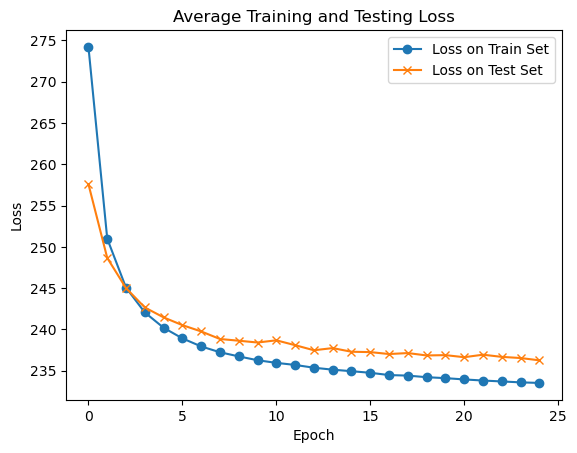

In [14]:
# print training and testing loss
plt.plot(train_losses, label='Loss on Train Set', marker='o')
plt.plot(test_losses, label='Loss on Test Set', marker='x')

# Setting the title and labels
plt.title('Average Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Adding a legend to indicate which line is which
plt.legend()

# Display the plot
plt.show()

**Visualize original and reconstructed images on test set for CVAE:**

In [15]:
def show(img1, img2):
    npimg1 = img1.cpu().numpy()
    npimg2 = img2.cpu().numpy()

    fig, axes = plt.subplots(1,2, figsize=(20,10))
    axes[0].imshow(np.transpose(npimg1, (1,2,0)), interpolation='nearest')
    axes[1].imshow(np.transpose(npimg2, (1,2,0)), interpolation='nearest')
    plt.show()

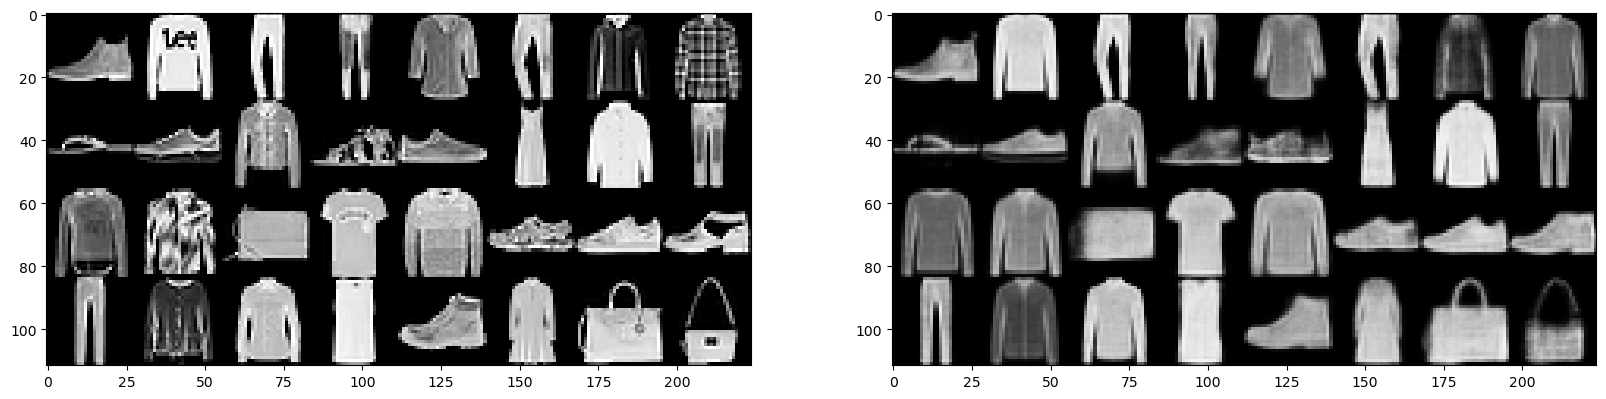

In [16]:
data, target = next(iter(test_loader))
data = data[:32]
target = target[:32]
data_size = data.size()
data = data.view(data.size(0),-1).to(device)
target = target.to(device)
output, _, _ = cvae(data, target)
output = output.detach()

show(make_grid(data.reshape(data_size), padding=0), make_grid(output.reshape(data_size), padding=0))

**Save Model Weights:**

In [17]:
torch.save(cvae.state_dict(), "cvae_best_weights.pth")
print("CVAE Model weights saved to 'cvae_best_weights.pth'")

CVAE Model weights saved to 'cvae_best_weights.pth'


### Manifold Comparison

Visualizing the latent space using t-distributed stochastic neighbor embedding.

In [18]:
def extract_mu(model, dataloader, device, conditional=False):

    model.eval()
    latent_mu = []
    labels = []
    
    with torch.no_grad():
        for data, target in dataloader:
            data = data.view(data.size(0), -1).to(device)
            target = target.to(device)
            
            if conditional:
                mu, _ = model.encode(data, target)  # pass class labels for C-VAE
            else:
                mu, _ = model.encode(data)  # VAE without class conditioning
            
            latent_mu.append(mu.numpy())
            labels.append(target.numpy())
    
    latent_mu = np.concatenate(latent_mu, axis=0)
    labels = np.concatenate(labels, axis=0)
    return latent_mu, labels


In [19]:
# apply function to extract latent means (mu)
cvae_mu, cvae_labels = extract_mu(cvae, test_loader, device, conditional=True)

In [20]:
def visualize_latent_space(latent_mu, labels, title):

    tsne = TSNE(n_components=2, random_state=42)
    #tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)

    latent_2d = tsne.fit_transform(latent_mu)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', s=10, alpha=0.8)
    plt.colorbar(scatter, ticks=range(10), label="Class Label")
    plt.title(title)
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.show()

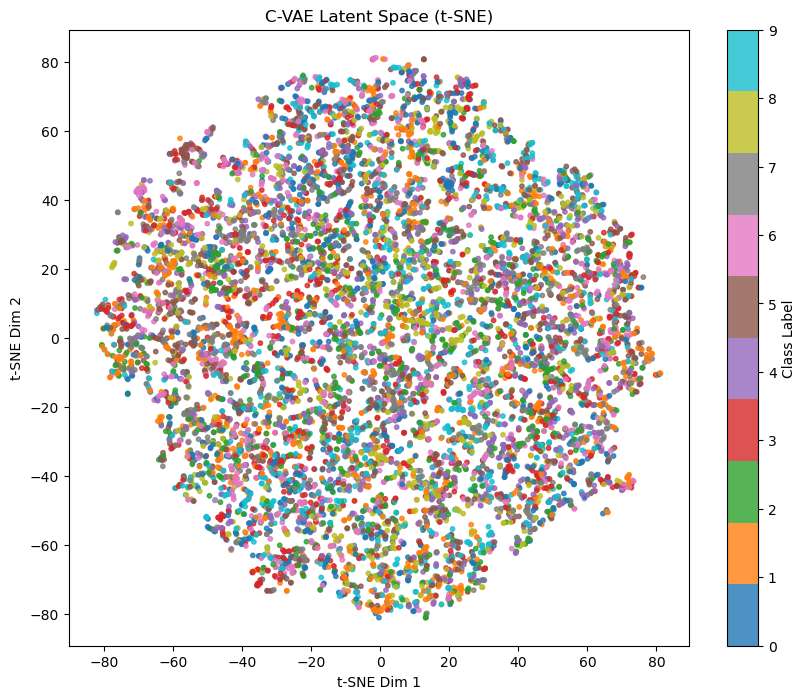

In [21]:
# apply function to visualize t-SNE projections
visualize_latent_space(cvae_mu, cvae_labels, title="C-VAE Latent Space (t-SNE)")

## Class Mappings using Conditional Input

**Dictionary**

In [22]:
# using '|' allowing a OR in regex
fashion_mnist_classes = {
    0: "T-shirt|top",
    1: "Trouser|Pants",
    2: "Pullover|Sweater|Hoodie",
    3: "Dress",
    4: "Coat|Jacket",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker|Shoe",
    8: "Bag",
    9: "Ankle boot|Boot"
}

**Helper Functions to Generate Images of a Specific Class:**

In [23]:
def generate_class(model, class_label, n_samples=7):
    """
    Generates samples for a specific class using the Conditional VAE.

    Args:
        model: The trained ConditionalVAE model.
        class_label: The target class to generate.
        n_samples: Number of samples to generate.
        z_dim: Dimensionality of the latent space.
        device: Device to run the generation (e.g., 'cpu' or 'cuda').

    Returns:
        Generated samples as a torch.Tensor.
    """
    model.eval()

    # 1. Sample latent variables from a standard normal distribution
    z_dim = model.fc31.out_features
    z = torch.randn(n_samples, z_dim).to(device)  # (n_samples, z_dim)

    # 2. Create a tensor of the target class labels
    class_labels = torch.tensor([class_label] * n_samples, dtype=torch.long).to(device)  # (n_samples,)

    # 3. Decode using the ConditionalVAE
    with torch.no_grad():
        generated_samples = model.decode(z, class_labels)

    return generated_samples

In [32]:
def show_generated_class(model, classes, class_label, n_samples=7):

    # Handle string input for class_label
    if isinstance(class_label, str):
        # Reverse mapping: word -> integer (match against any option for a class)
        matched_key = None
        for key, value in classes.items():
            regex = f'(?i)\\b({value})\\b'  # Build regex for each class
            if re.search(regex, class_label):  # Match input against regex
                matched_key = key
                break
        
        if matched_key is None:
            valid_options = [f"{key}: {value}" for key, value in classes.items()]
            raise ValueError(
                f"Invalid class name '{class_label}'. Valid options are:\n" + "\n".join(valid_options)
            )
        class_label = matched_key

    
    #  Handle integer input for class_label
    if class_label not in fashion_mnist_classes:
        raise ValueError(f"Invalid class label '{class_label}'. Valid options are integers 0-9 or class names.")


    # Generate samples
    generated_samples = generate_class(model, class_label, n_samples)

    # Set up the plot
    plt.figure(figsize=(15, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(generated_samples[i].numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
    
    # Add the class name as the overall title
    class_name = classes.get(class_label, "Unknown")
    plt.suptitle(f"Generated Samples for Class: {class_name}", fontsize=16, y=1.05)

    # Adjust layout
    plt.tight_layout()
    plt.show()

**Examples**

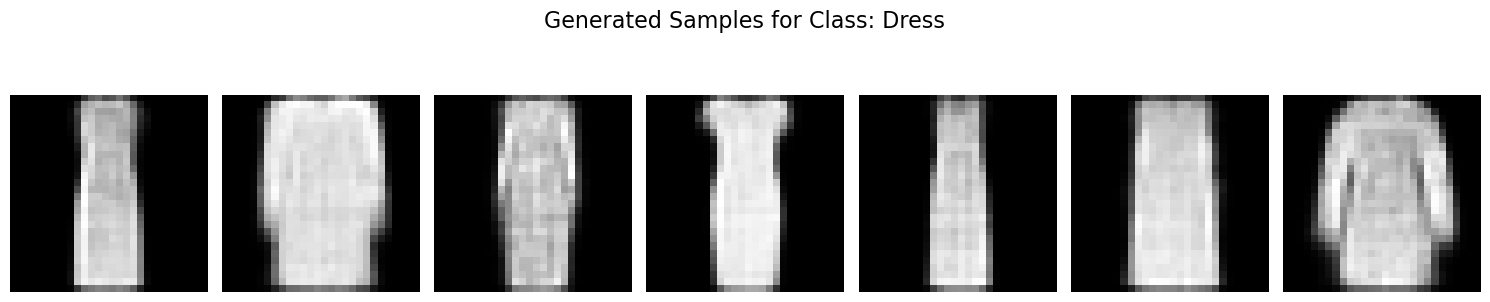

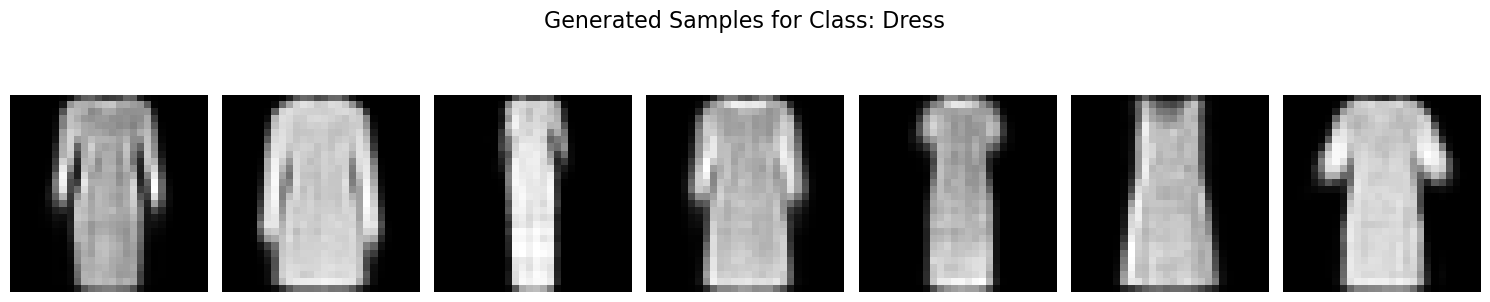

In [43]:
# Example 1: Using integer input
show_generated_class(cvae, fashion_mnist_classes, class_label=3)  # Generates and visualizes samples for "Dress"

# Example 2: Using string input
show_generated_class(cvae, fashion_mnist_classes, class_label="Dress")  # Generates and visualizes samples for "Dress"

# Example 3: Invalid string input
# This will raise a ValueError on purpose for an invalid class input
#show_generated_class(cvae, fashion_mnist_classes, class_label="InvalidClass")

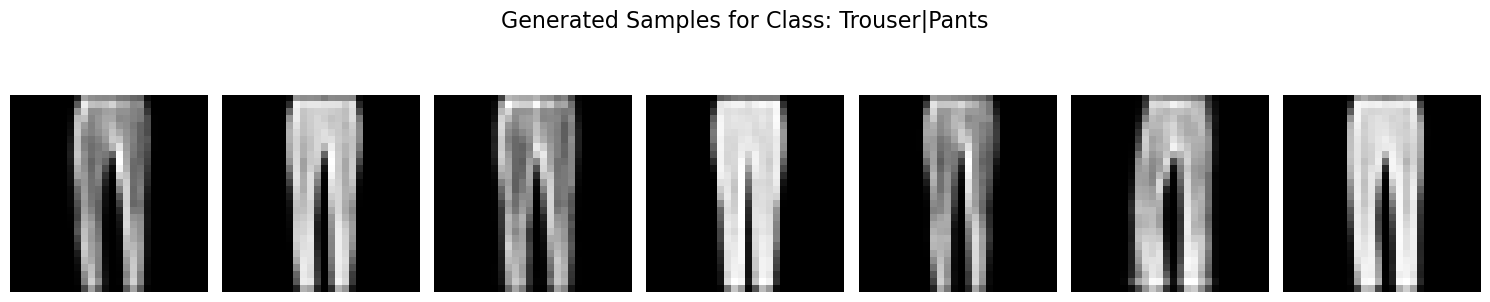

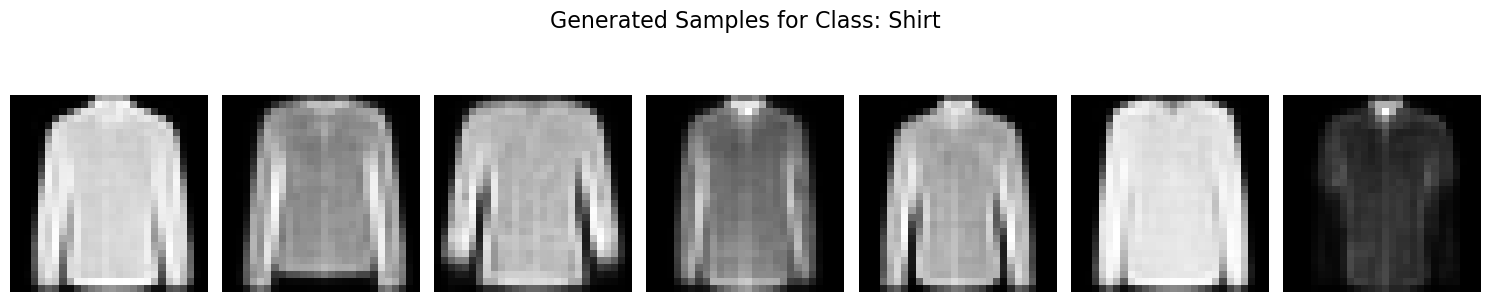

In [44]:
# Example 4: Using integer input
show_generated_class(cvae, fashion_mnist_classes, class_label="Trouser")  # Generates and visualizes samples for "Trouser"

# Example 5: Using string input
show_generated_class(cvae, fashion_mnist_classes, class_label="Shirt")  # Generates and visualizes samples for "Shirt"


**Now we define functions that allow the user to pass the class as an input.**

In [45]:
# map string value to integer key
def string_to_key(input_str, classes):
  for key in list(classes.keys()):
    regex = f'(?i)\\b({classes[key]})\\b'
    output = re.search(regex, input_str)
    if output: 
        return key
  return -1

def user_input(input_string, model, classes):
  label = string_to_key(input_str, classes)
  if label == -1: 
      return Exception("No valid class")
  show_generated_class(model, classes, class_label=label)
  return

Type Input Here: 


 Please generate images of a sweater.


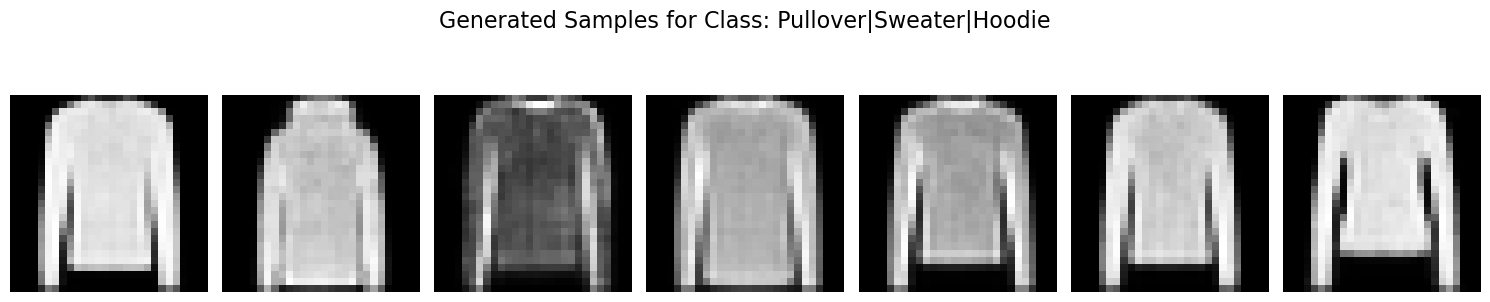

In [46]:
print('Type Input Here: ')
input_str = input()
user_input(input_str, cvae, fashion_mnist_classes)